# TIM Barrel
包含此结构的酶：  
Triose-phosphate isomerase  
ribulose-phosphate 3-epimerase  


直接使用关键词在UniProt中检索TIM Barrel结构的酶，并且限定其序列长度小于600，数据集下载链接为：  
https://rest.uniprot.org/uniprotkb/search?fields=accession%2Cid%2Cprotein_name%2Clength%2Cec%2Csequence&format=tsv&query=%28%28ec%3A*%29+AND+%28length%3A%5B*+TO+600%5D%29+AND+%22TIM+barrel%22+AND+%28reviewed%3Atrue%29%29&size=500

In [1]:
import pandas as pd
import os
from tqdm.auto import tqdm
from pandarallel import pandarallel
from rdkit import Chem
from tqdm import tqdm as top_tqdm

In [2]:
import os
import re
import requests
from requests.adapters import HTTPAdapter, Retry

re_next_link = re.compile(r'<(.+)>; rel="next"')
retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))

def get_next_link(headers):
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)

def get_batch(batch_url):
    while batch_url:
        response = session.get(batch_url)
        response.raise_for_status()
        total = response.headers["x-total-results"]
        yield response, total
        batch_url = get_next_link(response.headers)


url = 'https://rest.uniprot.org/uniprotkb/search?fields=accession%2Cid%2Cprotein_name%2Clength%2Cec%2Csequence&format=tsv&query=%28%28ec%3A*%29+AND+%28length%3A%5B*+TO+600%5D%29+AND+%22TIM+barrel%22+AND+%28reviewed%3Atrue%29%29&size=500'

progress = 0
tim_barrel_dataset_save_path ='./tim_barrel_raw_data'
dataset_fname = 'tim_barrel.tsv'
os.makedirs(tim_barrel_dataset_save_path, exist_ok=True)
if not os.path.exists(os.path.join(tim_barrel_dataset_save_path, dataset_fname)):
    with open(os.path.join(tim_barrel_dataset_save_path, dataset_fname), 'w') as f:
        for batch, total in get_batch(url):
            lines = batch.text.splitlines()
            if not progress:
                print(lines[0], file=f)
            for line in lines[1:]:
                print(line, file=f)
            progress += len(lines[1:])
            print(f'{progress} / {total}')

In [3]:


def get_database(dir):
    database_df = pd.DataFrame()
    csv_fnames = os.listdir(dir)
    pbar = tqdm(
        csv_fnames,
        total=len(csv_fnames)
    )
    for fname in pbar:
        df = pd.read_csv(os.path.join(dir, fname))
        df = df[['alphafolddb-id', 'aa_sequence', 'site_labels', 'site_types']]
        database_df = pd.concat([database_df, df])
    
    database_df = database_df.drop_duplicates(subset=['alphafolddb-id', 'aa_sequence','site_labels', 'site_types']).reset_index(drop=True)
    database_df['alphafolddb-id'] = database_df['alphafolddb-id'].apply(lambda x:x.replace(';',''))

    return database_df

def get_structure_sequence(pdb_file):
    try:
        mol = Chem.MolFromPDBFile(pdb_file)
        protein_sequence = Chem.MolToSequence(mol)
    except:
        protein_sequence = ''
    return protein_sequence

def multiprocess_structure_check(df, nb_workers, pdb_file_path):
    
    if nb_workers != 0:

        pandarallel.initialize(nb_workers=nb_workers, progress_bar=True)
        df['pdb_files'] = df['alphafolddb-id'].parallel_apply(
            lambda x: os.path.join(pdb_file_path, f'AF-{x}-F1-model_v4.pdb'))
        df['aa_sequence_calculated'] = df['pdb_files'].parallel_apply(
            lambda x: get_structure_sequence(x))
    else:
        top_tqdm.pandas(desc='pandas bar')
        df['pdb_files'] = df['alphafolddb-id'].progress_apply(
            lambda x: os.path.join(pdb_file_path, f'AF-{x}-F1-model_v4.pdb'))
        df['aa_sequence_calculated'] = df['pdb_files'].progress_apply(
            lambda x: get_structure_sequence(x))
    
    df['is_valid'] = (df['aa_sequence_calculated'] == df['aa_sequence'])

    return df

def get_query_database(path, pdb_file_path):
    database_df = pd.read_csv(path)
    database_df = database_df[['alphafolddb-id', 'aa_sequence','site_labels', 'site_types']]
    database_df['alphafolddb-id'] = database_df['alphafolddb-id'].apply(lambda x:x.replace(';',''))
    
    database_df = multiprocess_structure_check(database_df, nb_workers=12, pdb_file_path=pdb_file_path)
    

    return database_df

In [4]:
# 加载训练集，用于展示的数据不能在训练集中
train_dataset = get_database('../../dataset/ec_site_dataset/uniprot_ecreact_cluster_split_merge_dataset_limit_100/train_dataset')
valid_dataset = get_database('../../dataset/ec_site_dataset/uniprot_ecreact_cluster_split_merge_dataset_limit_100/valid_dataset')
tim_barrel_dataset = pd.read_csv(os.path.join(tim_barrel_dataset_save_path, dataset_fname), sep='\t')

  0%|          | 0/2595 [00:00<?, ?it/s]

  0%|          | 0/1011 [00:00<?, ?it/s]

In [5]:
train_dataset

,alphafolddb-id,aa_sequence,site_labels,site_types
0,P93149,MEPQLVAVSVLVSALICYFFFRPYFHRYGKNLPPSPFFRLPIIGHM...,[[448]],[0]
1,P9WGT3,MTATATEGAKPPFVSRSVLVTGGNRGIGLAIAQRLAADGHKVAVTH...,"[[25, 27], [47], [61, 62], [90], [153], [157],...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2]"
2,P71534,MTVTDNPADTAGEATAGRPAFVSRSVLVTGGNRGIGLAIARRLAAD...,"[[32, 35], [55], [69, 70], [98], [161], [165],...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2]"
3,P50203,MSEQKVALVTGALGGIGSEICRQLVTAGYKIIATVVPREEDREKQW...,"[[14, 16], [42], [90, 94], [96], [149, 152], [...","[0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,P50204,MAKVALVTGGSRGIGAAISKALKEAGYTVAANYAGNDDAARAFTEE...,"[[12, 14], [82, 86], [88], [141, 144], [177, 1...","[0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...
44788,A0A3Q7HBJ5,MELLYVCLVCVFVFLVSLLLLYKKKSGEGLPPGKTGWPVFGESLEF...,[[421]],[0]
44789,A5BFI4,MEVFFLSLLLICVLSVSIRLYLLLYKHRSHFTGPNLPPGKIGWPMV...,[[427]],[0]
44790,F6H9N6,MEVFFLSLLLIFVLSVSIGLHLLFYKHRSHFTGPNLPPGKIGWPMV...,[[427]],[0]
44791,A0A0U2U8U5,MYLTILFLFVSSILLSLMFLLRKHLSHFSYQNLPPGKTGFPLIGES...,[[422]],[0]


In [6]:
tim_barrel_dataset = tim_barrel_dataset.loc[~tim_barrel_dataset['Entry'].isin(train_dataset['alphafolddb-id'])].reset_index(drop=True)
tim_barrel_dataset

# todo 需要添加结构上的验证

,Entry,Entry Name,Protein names,Length,EC number,Sequence
0,P22936,APN1_YEAST,Apurinic-apyrimidinic endonuclease 1 (AP endon...,367,3.1.21.-,MPSTPSFVRSAVSKYKFGAHMSGAGGISNSVTNAFNTGCNSFAMFL...
1,P24215,UXUA_ECOLI,Mannonate dehydratase (EC 4.2.1.8) (D-mannonat...,394,4.2.1.8,MEQTWRWYGPNDPVSLADVRQAGATGVVTALHHIPNGEVWSVEEIL...
2,P0A6C1,END4_ECOLI,Endonuclease 4 (EC 3.1.21.2) (Endodeoxyribonuc...,285,3.1.21.2,MKYIGAHVSAAGGLANAAIRAAEIDATAFALFTKNQRQWRAAPLTT...
3,O50580,DT3E_PSECI,D-tagatose 3-epimerase (DTE) (EC 5.1.3.31) (D-...,290,5.1.3.31,MNKVGMFYTYWSTEWMVDFPATAKRIAGLGFDLMEISLGEFHNLSD...
4,Q10988,UVE1_SCHPO,UV-damage endonuclease (UVDE) (EC 3.-.-.-),599,3.-.-.-,MLRLLKRNIQISKRIVFTILKQKAFKGNHPCVPSVCTITYSRFHCL...
...,...,...,...,...,...,...
650,C3LHY0,IOLE_BACAC,Inosose dehydratase (EC 4.2.1.44) (2-keto-myo-...,298,4.2.1.44,MFKENTIKLGIAPIAWTNDDMPELGAENTFEQCISEMALAGFNGSE...
651,Q63B72,IOLE1_BACCZ,Inosose dehydratase 1 (EC 4.2.1.44) (2-keto-my...,298,4.2.1.44,MFKENTVKLGIAPIAWTNDDMPELGAGNTFEQCISEMALAGFNGSE...
652,Q65D04,IOLE_BACLD,Inosose dehydratase (EC 4.2.1.44) (2-keto-myo-...,300,4.2.1.44,MGKTQILWGIAPIGWRNDDIPEIGAGNTLQHLLSDIVVAGFQGTEV...
653,Q6HYJ1,IOLE_BACAN,Inosose dehydratase (EC 4.2.1.44) (2-keto-myo-...,298,4.2.1.44,MFKENTIKLGIAPIAWTNDDMPELGAENTFEQCISEMALAGFNGSE...


In [7]:
pdb_download_path = './pdb_download_folder'
pdb_download_path = os.path.abspath(pdb_download_path)
os.makedirs(pdb_download_path, exist_ok=True)
with open('./pdb_url.txt', 'w') as f:
    for uniprot_id in tqdm(tim_barrel_dataset['Entry'].tolist(), total=len(tim_barrel_dataset)):
        f.write(f'https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb\n')


  0%|          | 0/655 [00:00<?, ?it/s]

In [8]:
import subprocess
download_pdb_cmd = f'aria2c -i pdb_url.txt -j 5 -x 4 -c -d {pdb_download_path}'
if len(os.listdir(pdb_download_path)) == 0:
    subprocess.run(download_pdb_cmd, shell=True)


In [9]:
download_succ_ids = [x.split('-')[1] for x in os.listdir(pdb_download_path)]
tim_barrel_dataset = tim_barrel_dataset.loc[tim_barrel_dataset['Entry'].isin(download_succ_ids)].reset_index(drop=True)
tim_barrel_dataset

,Entry,Entry Name,Protein names,Length,EC number,Sequence
0,P22936,APN1_YEAST,Apurinic-apyrimidinic endonuclease 1 (AP endon...,367,3.1.21.-,MPSTPSFVRSAVSKYKFGAHMSGAGGISNSVTNAFNTGCNSFAMFL...
1,P24215,UXUA_ECOLI,Mannonate dehydratase (EC 4.2.1.8) (D-mannonat...,394,4.2.1.8,MEQTWRWYGPNDPVSLADVRQAGATGVVTALHHIPNGEVWSVEEIL...
2,P0A6C1,END4_ECOLI,Endonuclease 4 (EC 3.1.21.2) (Endodeoxyribonuc...,285,3.1.21.2,MKYIGAHVSAAGGLANAAIRAAEIDATAFALFTKNQRQWRAAPLTT...
3,O50580,DT3E_PSECI,D-tagatose 3-epimerase (DTE) (EC 5.1.3.31) (D-...,290,5.1.3.31,MNKVGMFYTYWSTEWMVDFPATAKRIAGLGFDLMEISLGEFHNLSD...
4,Q10988,UVE1_SCHPO,UV-damage endonuclease (UVDE) (EC 3.-.-.-),599,3.-.-.-,MLRLLKRNIQISKRIVFTILKQKAFKGNHPCVPSVCTITYSRFHCL...
...,...,...,...,...,...,...
642,C3LHY0,IOLE_BACAC,Inosose dehydratase (EC 4.2.1.44) (2-keto-myo-...,298,4.2.1.44,MFKENTIKLGIAPIAWTNDDMPELGAENTFEQCISEMALAGFNGSE...
643,Q63B72,IOLE1_BACCZ,Inosose dehydratase 1 (EC 4.2.1.44) (2-keto-my...,298,4.2.1.44,MFKENTVKLGIAPIAWTNDDMPELGAGNTFEQCISEMALAGFNGSE...
644,Q65D04,IOLE_BACLD,Inosose dehydratase (EC 4.2.1.44) (2-keto-myo-...,300,4.2.1.44,MGKTQILWGIAPIGWRNDDIPEIGAGNTLQHLLSDIVVAGFQGTEV...
645,Q6HYJ1,IOLE_BACAN,Inosose dehydratase (EC 4.2.1.44) (2-keto-myo-...,298,4.2.1.44,MFKENTIKLGIAPIAWTNDDMPELGAENTFEQCISEMALAGFNGSE...


In [10]:
from tim_barrel_detect import is_tim_barrel
tim_barrel_dataset['is_tim_barrel'] = tim_barrel_dataset['Entry'].apply(lambda x:is_tim_barrel(os.path.join(pdb_download_path, f'AF-{x}-F1-model_v4.pdb')))   # 粗略筛选 TIM barrel 结构

In [11]:
tim_barrel_dataset['is_tim_barrel'].sum()

577

In [12]:
tim_barrel_dataset = tim_barrel_dataset.loc[tim_barrel_dataset['is_tim_barrel']].reset_index(drop=True)

In [13]:
dataset_path = '../../dataset/ec_site_dataset/uniprot_ecreact_cluster_split_merge_dataset_limit_100'
test_dataset = get_query_database(os.path.join(dataset_path, 'test_dataset', 'uniprot_ecreact_merge.csv'), pdb_file_path=os.path.join(os.path.dirname(dataset_path), 'structures', 'alphafolddb_download'))

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [14]:
test_dataset = test_dataset.loc[test_dataset['is_valid']].reset_index(drop=True)
test_dataset

,alphafolddb-id,aa_sequence,site_labels,site_types,pdb_files,aa_sequence_calculated,is_valid
0,A0A1S7LCW6,MKLKGTTIVALGMLVVAIMVLASMIDLPGSDMSATPAPPDTPRGAP...,"[[206], [212], [215], [216], [246], [252], [25...","[0, 0, 0, 0, 0, 0, 0, 0]",../../dataset/ec_site_dataset/structures/alpha...,MKLKGTTIVALGMLVVAIMVLASMIDLPGSDMSATPAPPDTPRGAP...,True
1,Q9F0J6,MQATKIIDGFHLVGAIDWNSRDFHGYTLSPMGTTYNAYLVEDEKTT...,"[[79], [81], [83], [146], [165], [165], [226]]","[0, 0, 0, 0, 0, 0, 0]",../../dataset/ec_site_dataset/structures/alpha...,MQATKIIDGFHLVGAIDWNSRDFHGYTLSPMGTTYNAYLVEDEKTT...,True
2,Q5BEJ7,MADHEQEQEPLSIAIIGGGIIGLMTALGLLHRNIGKVTIYERASAW...,"[[41, 42], [245, 247], [320], [330, 334]]","[0, 0, 0, 0]",../../dataset/ec_site_dataset/structures/alpha...,MADHEQEQEPLSIAIIGGGIIGLMTALGLLHRNIGKVTIYERASAW...,True
3,Q9HUH4,MPQALSTDILIVGGGIAGLWLNARLRRAGYATVLVESASLGGGQSV...,"[[17], [36], [44, 45], [49, 51], [346, 347]]","[0, 0, 0, 0, 0]",../../dataset/ec_site_dataset/structures/alpha...,MPQALSTDILIVGGGIAGLWLNARLRRAGYATVLVESASLGGGQSV...,True
4,P96692,MAEFTHLVNERRSASNFLSGHPITKEDLNEMFELVALAPSAFNLQH...,"[[11, 13], [68, 70], [157, 158], [193], [196]]","[0, 0, 0, 0, 0]",../../dataset/ec_site_dataset/structures/alpha...,MAEFTHLVNERRSASNFLSGHPITKEDLNEMFELVALAPSAFNLQH...,True
...,...,...,...,...,...,...,...
887,O30144,MFLKVRAEKRLGNFRLNVDFEMGRDYCVLLGPTGAGKSVFLELIAG...,"[[31, 38]]",[0],../../dataset/ec_site_dataset/structures/alpha...,MFLKVRAEKRLGNFRLNVDFEMGRDYCVLLGPTGAGKSVFLELIAG...,True
888,P28737,MSRKFDLKTITDLSVLVGTGISLYYLVSRLLNDVESGPLSGKSRES...,"[[133, 140]]",[0],../../dataset/ec_site_dataset/structures/alpha...,MSRKFDLKTITDLSVLVGTGISLYYLVSRLLNDVESGPLSGKSRES...,True
889,P37093,MTEMVISPAERQSIRRLPFSFANRFKLVLDWNEDFSQASIYYLAPL...,"[[397], [400], [430], [433]]","[0, 0, 0, 0]",../../dataset/ec_site_dataset/structures/alpha...,MTEMVISPAERQSIRRLPFSFANRFKLVLDWNEDFSQASIYYLAPL...,True
890,P94360,MAELRMEHIYKFYDQKEPAVDDFNLHIADKEFIVFVGPSGCGKSTT...,"[[37, 44]]",[0],../../dataset/ec_site_dataset/structures/alpha...,MAELRMEHIYKFYDQKEPAVDDFNLHIADKEFIVFVGPSGCGKSTT...,True


In [15]:
test_dataset_tim_barrel = test_dataset.loc[test_dataset['alphafolddb-id'].isin(tim_barrel_dataset['Entry'])].reset_index(drop=True)
test_dataset_tim_barrel

,alphafolddb-id,aa_sequence,site_labels,site_types,pdb_files,aa_sequence_calculated,is_valid
0,P08997,MTEQATTTDELAFTRPYGEQEKQILTAEAVEFLTELVTHFTPQRNK...,"[[166], [447]]","[1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MTEQATTTDELAFTRPYGEQEKQILTAEAVEFLTELVTHFTPQRNK...,True
1,A0A1L7NQ96,MKIGCHGLVWTGHFDAEGIRYSVQKTREAGFDLVEFPLMDPFSFDV...,"[[146], [152], [179, 182], [179], [205], [211]...","[0, 0, 0, 0, 0, 0, 0, 1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MKIGCHGLVWTGHFDAEGIRYSVQKTREAGFDLVEFPLMDPFSFDV...,True
2,P76044,MKIGTQNQAFFPENILEKFRYIKEMGFDGFEIDGKLLVNNIEEVKA...,"[[146], [179], [182], [205], [211], [240], [14...","[0, 0, 0, 0, 0, 0, 1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MKIGTQNQAFFPENILEKFRYIKEMGFDGFEIDGKLLVNNIEEVKA...,True
3,B8I944,MKHGIYYAYWEQEWEADYKYYIEKVAKLGFDILEIAASPLPFYSDI...,"[[6], [107], [150], [156], [183, 186], [183], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MKHGIYYAYWEQEWEADYKYYIEKVAKLGFDILEIAASPLPFYSDI...,True
4,Q9KCL9,MSMKSQFERAKIEYGQWGIDVEEALERLKQVPISIHCWQGDDVGGF...,"[[261], [293], [295]]","[0, 0, 0]",../../dataset/ec_site_dataset/structures/alpha...,MSMKSQFERAKIEYGQWGIDVEEALERLKQVPISIHCWQGDDVGGF...,True
5,P50910,MSYQPTPEDKFTFGLWTVGWQGRDPFGDATRGALDPAESVRRLAEL...,"[[181], [217], [217], [220], [245], [255], [25...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MSYQPTPEDKFTFGLWTVGWQGRDPFGDATRGALDPAESVRRLAEL...,True


In [16]:
test_dataset_tim_barrel['ec'] = test_dataset_tim_barrel['alphafolddb-id'].apply(lambda x:tim_barrel_dataset.loc[tim_barrel_dataset["Entry"] == x]['EC number'].tolist()[0])

In [17]:
test_dataset_tim_barrel = test_dataset_tim_barrel.reset_index(drop=True)

In [18]:
test_dataset_tim_barrel

,alphafolddb-id,aa_sequence,site_labels,site_types,pdb_files,aa_sequence_calculated,is_valid,ec
0,P08997,MTEQATTTDELAFTRPYGEQEKQILTAEAVEFLTELVTHFTPQRNK...,"[[166], [447]]","[1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MTEQATTTDELAFTRPYGEQEKQILTAEAVEFLTELVTHFTPQRNK...,True,2.3.3.9
1,A0A1L7NQ96,MKIGCHGLVWTGHFDAEGIRYSVQKTREAGFDLVEFPLMDPFSFDV...,"[[146], [152], [179, 182], [179], [205], [211]...","[0, 0, 0, 0, 0, 0, 0, 1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MKIGCHGLVWTGHFDAEGIRYSVQKTREAGFDLVEFPLMDPFSFDV...,True,5.1.3.-
2,P76044,MKIGTQNQAFFPENILEKFRYIKEMGFDGFEIDGKLLVNNIEEVKA...,"[[146], [179], [182], [205], [211], [240], [14...","[0, 0, 0, 0, 0, 0, 1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MKIGTQNQAFFPENILEKFRYIKEMGFDGFEIDGKLLVNNIEEVKA...,True,5.1.3.-
3,B8I944,MKHGIYYAYWEQEWEADYKYYIEKVAKLGFDILEIAASPLPFYSDI...,"[[6], [107], [150], [156], [183, 186], [183], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MKHGIYYAYWEQEWEADYKYYIEKVAKLGFDILEIAASPLPFYSDI...,True,5.1.3.30
4,Q9KCL9,MSMKSQFERAKIEYGQWGIDVEEALERLKQVPISIHCWQGDDVGGF...,"[[261], [293], [295]]","[0, 0, 0]",../../dataset/ec_site_dataset/structures/alpha...,MSMKSQFERAKIEYGQWGIDVEEALERLKQVPISIHCWQGDDVGGF...,True,5.3.1.14
5,P50910,MSYQPTPEDKFTFGLWTVGWQGRDPFGDATRGALDPAESVRRLAEL...,"[[181], [217], [217], [220], [245], [255], [25...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",../../dataset/ec_site_dataset/structures/alpha...,MSYQPTPEDKFTFGLWTVGWQGRDPFGDATRGALDPAESVRRLAEL...,True,5.3.1.5


In [19]:
import sys

sys.path.append("../../")
from webapp.utils import (
    EasIFAInferenceAPI,
    UniProtParserMysql,
    retrain_ec_site_model_state_path,
    get_structure_html_and_active_data,
    cmd,
)
easifa_predictor = EasIFAInferenceAPI(
    model_checkpoint_path=retrain_ec_site_model_state_path
)

def inference(rxn_smiles, enzyme_structure_path):
    pred_active_site_labels = easifa_predictor.inference(
        rxn=rxn_smiles, enzyme_structure_path=enzyme_structure_path
    )
    structure_html, active_data = get_structure_html_and_active_data(
        enzyme_structure_path=enzyme_structure_path,
        site_labels=pred_active_site_labels,
        view_size=(600, 600),
    )
    return structure_html, active_data



/home/xiaoruiwang/software/miniconda3/envs/py38/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/script/TIM_barrel_study/../../model_structure/esm_layer.py:297: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Reaction attention model from scratch...
Loaded checkpoint from /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/checkpoints/enzyme_site_type_predition_model/train_in_uniprot_ecreact_cluster_split_merge_dataset_limit_100_at_2024-05-26-02-48-38/global_step_86000


In [20]:
unprot_mysql_parser = UniProtParserMysql(
    mysql_config_path="../../webapp/mysql_config.json"
)

[Errno 2] No such file or directory: '../../webapp/mysql_config.json'


In [21]:
test_dataset_tim_barrel_pred_results = []
for idx, row in tqdm(test_dataset_tim_barrel.iterrows(), total=len(test_dataset_tim_barrel)):
    uniprot_id = row['alphafolddb-id']
    query_data, _, _ = unprot_mysql_parser.query_from_uniprot(uniprot_id)
    _, query_results_df, _, _ = query_data
    rxn_smiles = query_results_df["rxn_smiles"].tolist()[0]
    enzyme_structure_path = os.path.join(pdb_download_path, f"AF-{uniprot_id}-F1-model_v4.pdb")
    if not os.path.exists(enzyme_structure_path):  # 真酶结构
        enzyme_structure_path = os.path.join(
            unprot_mysql_parser.unprot_parser.alphafolddb_folder,
            f"AF-{uniprot_id}-F1-model_v4.pdb",
        )
        cmd(unprot_mysql_parser.unprot_parser.download_alphafolddb_url_template.format(enzyme_structure_path, uniprot_id))
    structure_html, active_data = inference(rxn_smiles=rxn_smiles, enzyme_structure_path=enzyme_structure_path)
    active_data_df = pd.DataFrame(active_data, columns=['Residue Index', 'Residue Name', 'Color', 'Active  Site Type'])
    test_dataset_tim_barrel_pred_results.append((uniprot_id, structure_html, active_data_df, row['site_labels'], row['site_types'], row['ec'], rxn_smiles))


  0%|          | 0/6 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
[Errno 2] No such file or directory: '../../webapp/mysql_config.json'


In [22]:
from collections import defaultdict
from IPython.display import display, HTML, IFrame, SVG
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem

def draw_chemical_reaction(smiles, highlightByReactant=False, font_scale=1.5):
    rxn = rdChemReactions.ReactionFromSmarts(smiles,useSmiles=True)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    d2d = rdMolDraw2D.MolDraw2DSVG(800,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)

    d2d.FinishDrawing()

    return d2d.GetDrawingText()

def show_one_results(one_result):
    print('\n' + '#'*20 + '\n')
    print(f'UnProtID = {one_result[0]}, EC Number = {one_result[5]}')
    print('\n' + '#'*20 + '\n')
    print('Enzymatic Reaction:')
    print(f'Reaction SMILES:\n{one_result[6]}')
    display(SVG(draw_chemical_reaction(one_result[6])))
    print('\n' + '#'*20 + '\n')
    print('Predicted Active Sites:')
    display(HTML(one_result[1]))
    display(one_result[2])
    print('\n' + '#'*20 + '\n')
    print('Ground Truth:')
    display(IFrame(f'https://www.uniprot.org/uniprotkb/{one_result[0]}/entry', width=1200, height=900))


####################

UnProtID = P08997, EC Number = 2.3.3.9

####################

Enzymatic Reaction:
Reaction SMILES:
CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-].O.O=CC(=O)[O-]>>CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCS.O=C([O-])C[C@H](O)C(=O)[O-].[H+]


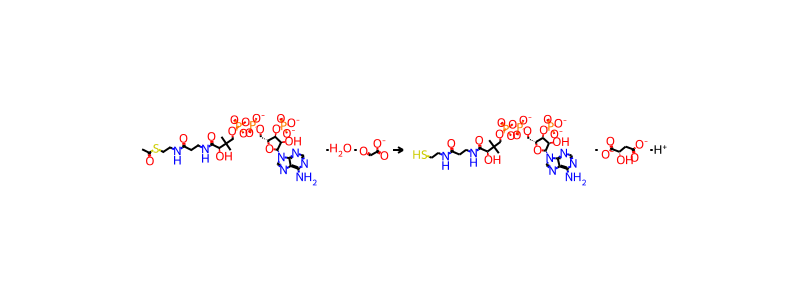


####################

Predicted Active Sites:


,Residue Index,Residue Name,Color,Active Site Type
0,166,ARG,#00B050,Catalytic Site
1,447,ASP,#00B050,Catalytic Site



####################

Ground Truth:


In [23]:
show_one_results(test_dataset_tim_barrel_pred_results[0])


####################

UnProtID = A0A1L7NQ96, EC Number = 5.1.3.-

####################

Enzymatic Reaction:
Reaction SMILES:
O=C(CO)[C@@H](O)[C@@H](O)CO>>O=C(CO)[C@H](O)[C@@H](O)CO


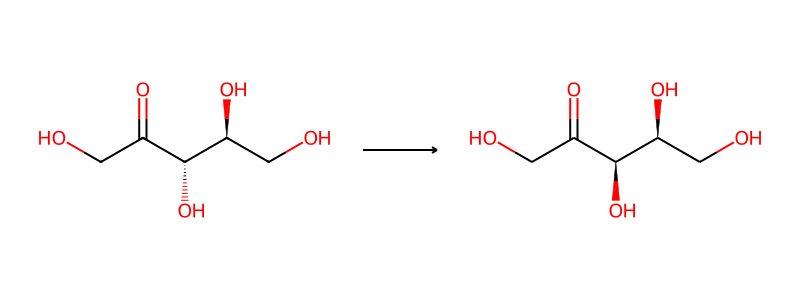


####################

Predicted Active Sites:


,Residue Index,Residue Name,Color,Active Site Type
0,146,GLU,#00B050,Catalytic Site
1,152,GLU,#FF0000,Binding Site
2,179,ASP,#FF0000,Binding Site
3,180,THR,#FF0000,Binding Site
4,181,TYR,#FF0000,Binding Site
5,182,HIS,#FF0000,Binding Site
6,205,HIS,#FF0000,Binding Site
7,211,ARG,#FF0000,Binding Site
8,240,GLU,#00B050,Catalytic Site



####################

Ground Truth:


In [24]:
show_one_results(test_dataset_tim_barrel_pred_results[1])


####################

UnProtID = P76044, EC Number = 5.1.3.-

####################

Enzymatic Reaction:
Reaction SMILES:
*OC1O[C@H](CO)[C@H](O)C(=O)[C@H]1O>>*OC1O[C@H](CO)[C@@H](O)C(=O)[C@H]1O


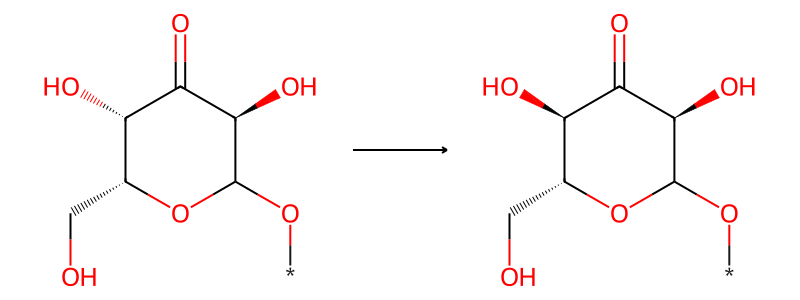


####################

Predicted Active Sites:


,Residue Index,Residue Name,Color,Active Site Type
0,146,GLU,#00B050,Catalytic Site
1,152,GLN,#FF0000,Binding Site
2,179,ASP,#FF0000,Binding Site
3,182,HIS,#FF0000,Binding Site
4,205,HIS,#FF0000,Binding Site
5,211,ARG,#FF0000,Binding Site
6,240,GLU,#00B050,Catalytic Site



####################

Ground Truth:


In [25]:
show_one_results(test_dataset_tim_barrel_pred_results[2])


####################

UnProtID = B8I944, EC Number = 5.1.3.30

####################

Enzymatic Reaction:
Reaction SMILES:
O=C(CO)[C@H](O)[C@H](O)[C@H](O)CO>>O=C(CO)[C@@H](O)[C@H](O)[C@H](O)CO


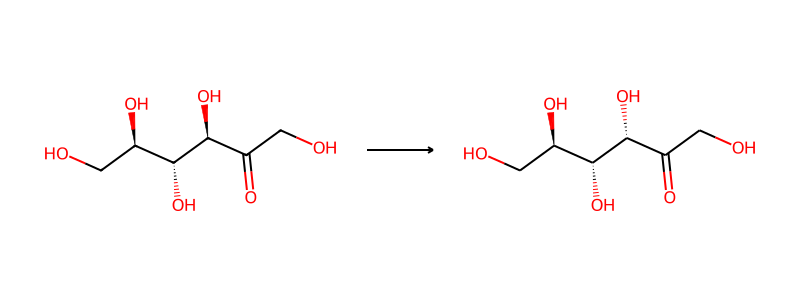


####################

Predicted Active Sites:


,Residue Index,Residue Name,Color,Active Site Type
0,150,GLU,#00B050,Catalytic Site
1,156,GLU,#FF0000,Binding Site
2,183,ASP,#FF0000,Binding Site
3,184,THR,#FF0000,Binding Site
4,185,PHE,#FF0000,Binding Site
5,186,HIS,#FF0000,Binding Site
6,209,HIS,#FF0000,Binding Site
7,215,ARG,#FF0000,Binding Site
8,244,GLU,#00B050,Catalytic Site



####################

Ground Truth:


In [26]:
show_one_results(test_dataset_tim_barrel_pred_results[3])


####################

UnProtID = Q9KCL9, EC Number = 5.3.1.14

####################

Enzymatic Reaction:
Reaction SMILES:
C[C@@H]1OC(O)[C@H](O)[C@H](O)[C@H]1O>>C[C@H](O)[C@H](O)[C@@H](O)C(=O)CO


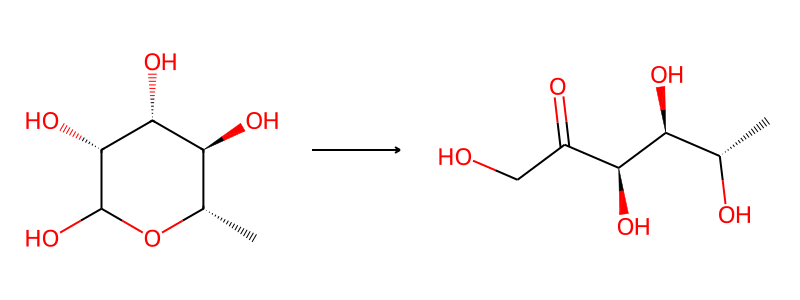


####################

Predicted Active Sites:


,Residue Index,Residue Name,Color,Active Site Type
0,261,HIS,#FF0000,Binding Site
1,293,ASP,#FF0000,Binding Site
2,295,ASP,#FF0000,Binding Site



####################

Ground Truth:


In [27]:
show_one_results(test_dataset_tim_barrel_pred_results[4])


####################

UnProtID = P50910, EC Number = 5.3.1.5

####################

Enzymatic Reaction:
Reaction SMILES:
O[C@@H]1[C@@H](O)[C@@H](O)OC[C@H]1O>>OC[C@]1(O)OC[C@@H](O)[C@@H]1O


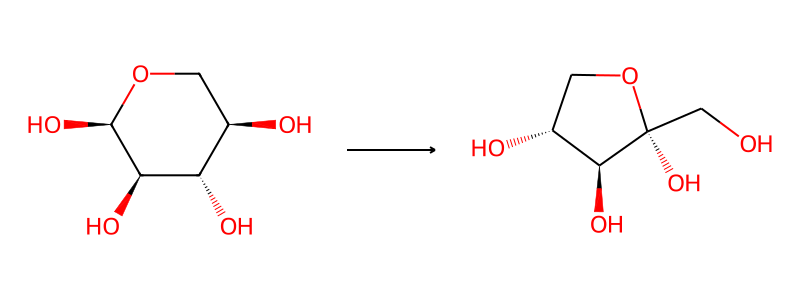


####################

Predicted Active Sites:


,Residue Index,Residue Name,Color,Active Site Type
0,54,HIS,#00B050,Catalytic Site
1,57,ASP,#00B050,Catalytic Site
2,181,GLU,#FF0000,Binding Site
3,217,GLU,#FF0000,Binding Site
4,220,HIS,#FF0000,Binding Site
5,245,ASP,#FF0000,Binding Site
6,255,ASP,#FF0000,Binding Site
7,257,ASP,#FF0000,Binding Site
8,287,ASP,#FF0000,Binding Site



####################

Ground Truth:


In [28]:
show_one_results(test_dataset_tim_barrel_pred_results[5])